Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.base import clone
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("adult.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Отсутсвующих значений нет

In [5]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


численные столбцы

In [6]:
num_columns = list(data.select_dtypes(np.number).columns)
num_columns

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [7]:
df_objects = data[data.select_dtypes(np.object).columns]
pd.DataFrame(
    [(c, len(df_objects[c].unique())) for c in df_objects.columns],
    columns=["Имя столбца", "Количество уникальных значений"])

,Имя столбца,Количество уникальных значений
0,workclass,9
1,education,16
2,marital-status,7
3,occupation,15
4,relationship,6
5,race,5
6,gender,2
7,native-country,42
8,income,2


income - это предсказываемое значение, преобразовываем его с помощью label encoding. Остальные столбцы преобразовываем с помощью one hot encoding

In [8]:
ohe_columns = [c for c in data.select_dtypes(np.object).columns if c != 'income']
ohe_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

Конструируем преобразователь входных данных

In [9]:
converter = make_column_transformer(
    (StandardScaler(), num_columns),
    (make_pipeline(OneHotEncoder(sparse=False), StandardScaler()), ohe_columns),
    (OrdinalEncoder(dtype=np.int8), ["income"])
)

In [10]:
prepared_data = converter.fit_transform(data)
prepared_data.shape

(48842, 109)

In [11]:
converter.transformers_

[('standardscaler',
  StandardScaler(copy=True, with_mean=True, with_std=True),
  ['age',
   'fnlwgt',
   'educational-num',
   'capital-gain',
   'capital-loss',
   'hours-per-week']),
 ('pipeline', Pipeline(memory=None,
           steps=[('onehotencoder',
                   OneHotEncoder(categorical_features=None, categories=None,
                                 drop=None, dtype=<class 'numpy.float64'>,
                                 handle_unknown='error', n_values=None,
                                 sparse=False)),
                  ('standardscaler',
                   StandardScaler(copy=True, with_mean=True, with_std=True))],
           verbose=False), ['workclass',
   'education',
   'marital-status',
   'occupation',
   'relationship',
   'race',
   'gender',
   'native-country']),
 ('ordinalencoder',
  OrdinalEncoder(categories='auto', dtype=<class 'numpy.int8'>),
  ['income'])]

In [12]:
column_names = num_columns + list(converter.named_transformers_["pipeline"]["onehotencoder"].get_feature_names(ohe_columns)) + ["income"]
print(column_names)

['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_?', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'oc

Расшифровка таргета

In [13]:
converter.named_transformers_['ordinalencoder'].categories_

[array(['<=50K', '>50K'], dtype=object)]

In [14]:
X, y = prepared_data[:, :-1], prepared_data[:,-1:].ravel()

In [15]:
X.shape, y.shape

((48842, 108), (48842,))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

Произведем подбор гиперпараметров для разных моделей. Для постройки ROC Curve и просчета ROC AUC требуется вероятности прогнозов, поэтому выбираем классификаторы поддерживающие прогнозирование с вероятностями.

In [17]:
def find_best_params_for_models(models, n_varants=None):
    def random_search_cv(estimator, params, **nargs):
        return RandomizedSearchCV(estimator, params, n_iter=n_varants, **nargs)
    
    results = []
    search_algorithm = GridSearchCV if n_varants is None else random_search_cv
    for classifier, params in models:
        gs = search_algorithm(classifier, params, cv=5, n_jobs=-1, verbose=1)
        gs.fit(X_train, y_train)
        y_pred = gs.predict_proba(X_val)[:,1]
        # name, roc_curve, roc_auc, params
        curve = roc_curve(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)
        params = gs.best_params_
        
        results.append((classifier.__class__.__name__, curve, auc, params))
    
    return results

def choose_random_params_for_model(model, count):
    results = []
    classifier, params = model
    if hasattr(params, 'items'):
        params = [params]
    for _ in range(count):
        params_dict = params[random.randint(0, len(params)-1)]
        model_dict = { key : value[random.randint(0, len(value)-1)] for (key, value) in params_dict.items()}
        c = clone(classifier)
        c.set_params(**model_dict)
        c.fit(X_train, y_train)
        y_pred = c.predict_proba(X_val)[:,1]
        # name, roc_curve, roc_auc, params
        curve = roc_curve(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)

        results.append((classifier.__class__.__name__, curve, auc, model_dict))
   
    return results

def show_roc_curve_for_models(models):
    plt.figure(figsize=(13,10))
    legend = []
    for name, curve, roc_auc, params in models:
        plt.plot(curve[0], curve[1])
        legend.append("{}, roc_auc={}, params={}".format(name, roc_auc, params))
    plt.legend(legend)
    plt.show()

Логистическая регрессия

In [18]:
base_logistic_regression_params = dict(
    C = [1.0, 10.0],
    max_iter = [100, 200],
)
    
logistic_regression_params = (LogisticRegression(), [
    dict(
        **base_logistic_regression_params,
        solver=['newton-cg', 'lbfgs', 'sag'],
        penalty=['l2', 'none']
        
    ),
    dict(
        **base_logistic_regression_params,
        solver=['liblinear'],
        penalty=['l1', 'l2']
    ),
    dict(
        **base_logistic_regression_params,
        solver=['saga'],
        penalty=['l1', 'l2', 'none']
    ),
    dict(
        **base_logistic_regression_params,
        solver=['saga'],
        penalty=['elasticnet'],
        l1_ratio=[0.2,0.5,0.8]
    )
])

In [19]:
%%time
logistic_regression_best_params = find_best_params_for_models([logistic_regression_params])

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 18.3min finished


Wall time: 18min 59s


In [20]:
%%time

logistic_regression_results = [
    *logistic_regression_best_params,
    *choose_random_params_for_model(logistic_regression_params, 4)
]

Wall time: 45 s


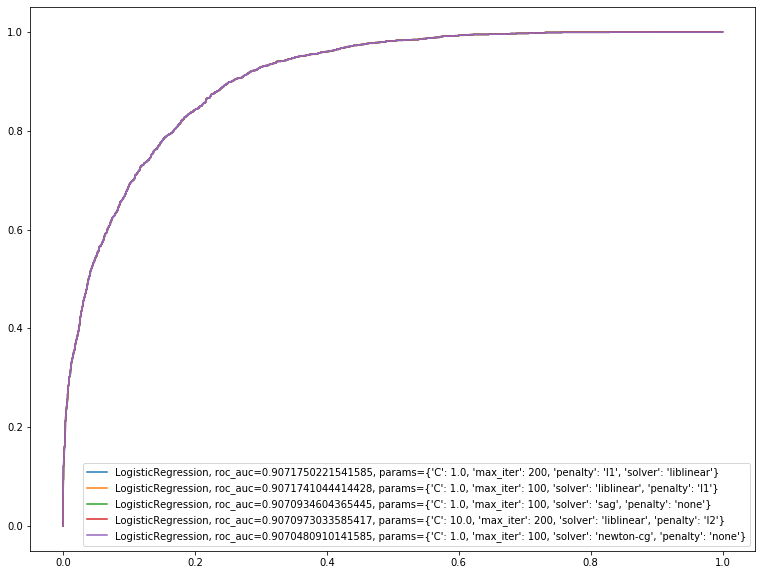

In [34]:
show_roc_curve_for_models(logistic_regression_results)

Алгоритм KNN

In [21]:
knn_params = (KNeighborsClassifier(),
    dict(
        n_neighbors=[1, 5, 10],
        weights = ['uniform', 'distance'],
        algorithm = ['ball_tree', 'kd_tree', 'brute'],
        leaf_size = [30, 50],
        p = [1, 2]
    ))

In [22]:
%%time
knn_best_params = find_best_params_for_models([knn_params], n_varants=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.2min finished


Wall time: 10min 35s


In [23]:
%%time

knn_results = [
    *knn_best_params,
    *choose_random_params_for_model(knn_params, 4)
]

Wall time: 5min 14s


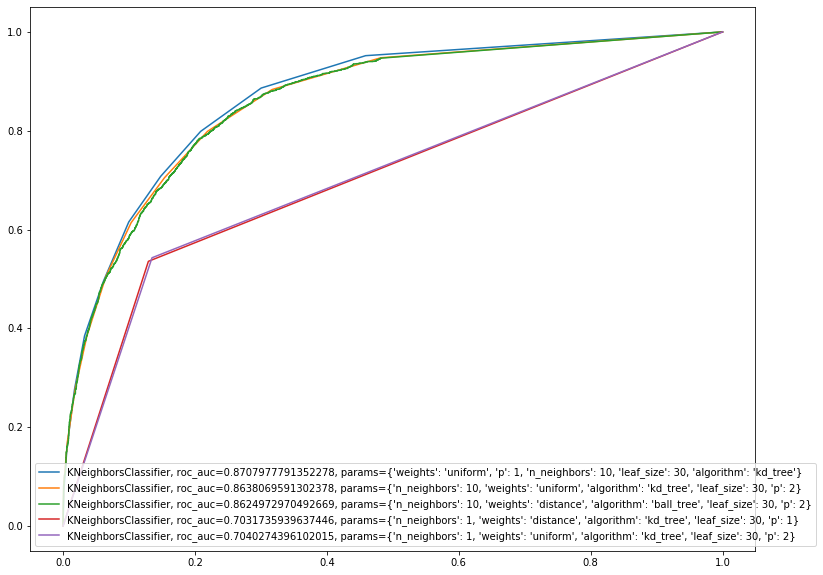

In [24]:
show_roc_curve_for_models(knn_results)

Также попробуем "деревянный" классификатор

In [25]:
tree_params = (DecisionTreeClassifier(),
    dict(
        criterion=['gini', 'entropy'],
        splitter = ['best', 'random'],
        max_depth = [None, 100, 500, 1000],
        min_samples_split = [2, 4, 8],
        min_samples_leaf = [1, 2, 3]
    ))

In [26]:
%%time
tree_best_params = find_best_params_for_models([tree_params])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.4min finished


Wall time: 4min 26s


In [27]:
%%time

tree_results = [
    *tree_best_params,
    *choose_random_params_for_model(tree_params, 4)
]

Wall time: 3.98 s


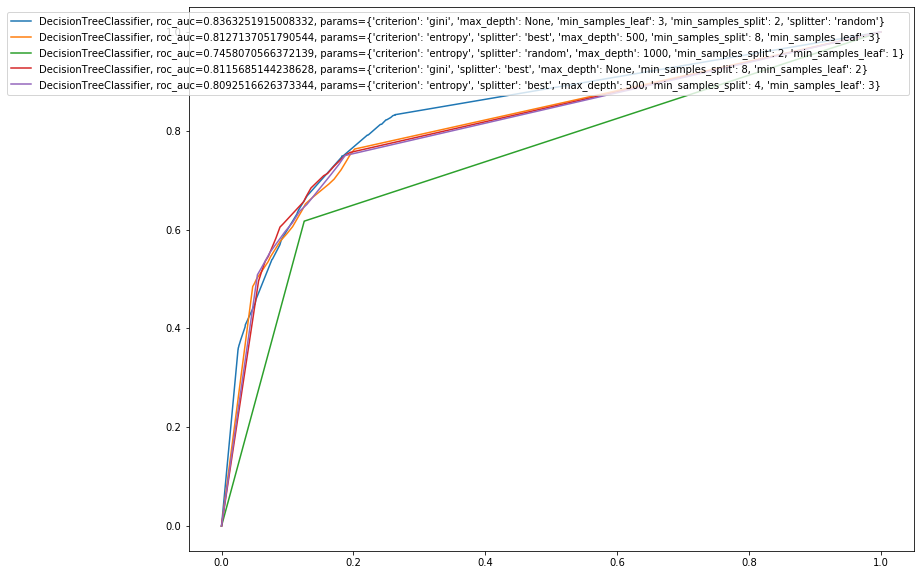

In [28]:
show_roc_curve_for_models(tree_results)

И последний вариант в сравнение это многослойный перцептрон

In [29]:
mlp_params = (MLPClassifier(),
    dict(
        hidden_layer_sizes = [(100,), (50,50), (100, 50, 25)],
        activation = ['identity', 'logistic', 'tanh', 'relu'],
        solver = ['lbfgs', 'sgd', 'adam'],
        learning_rate = ['constant', 'invscaling', 'adaptive']
    ))

In [30]:
%%time
mlp_best_params = find_best_params_for_models([mlp_params], n_varants=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  7.7min finished


Wall time: 8min 40s


In [31]:
%%time

mlp_results = [
    *mlp_best_params,
    *choose_random_params_for_model(mlp_params, 4)
]

Wall time: 2min 52s


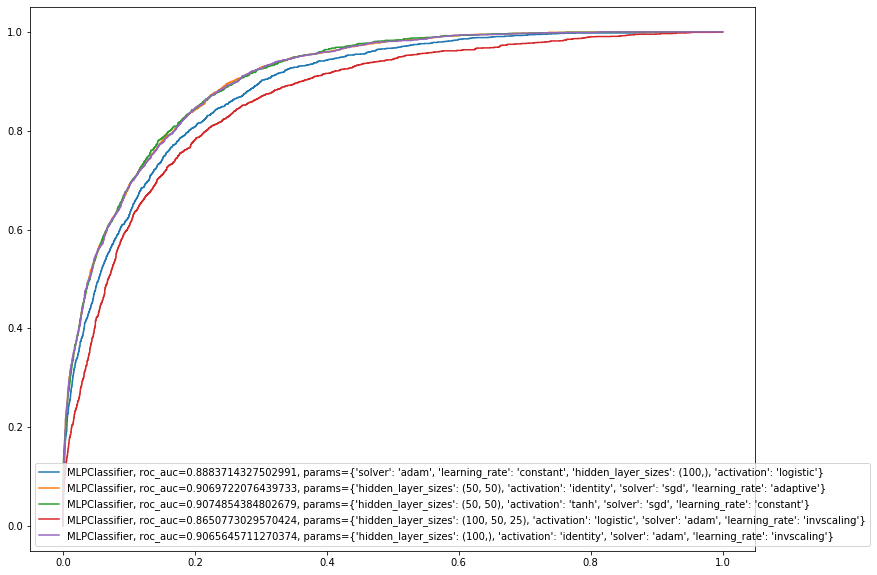

In [32]:
show_roc_curve_for_models(mlp_results)

Совместим все лучшие варианты на одном графике

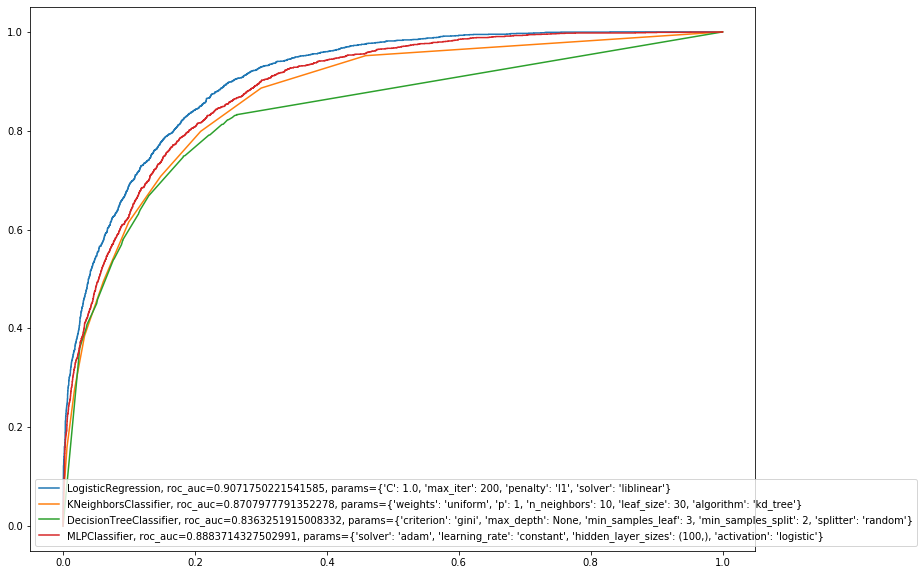

In [33]:
best_results = [
    *logistic_regression_best_params,
    *knn_best_params,
    *tree_best_params,
    *mlp_best_params
]
show_roc_curve_for_models(best_results)